In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from datetime import datetime
from keras.layers import LSTM, Dense, Dropout
from keras.models import Sequential

from sklearn.preprocessing import MinMaxScaler

In [ ]:
df = pd.read_csv('stocks.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

Epoch 1/20
55/55 - 12s - loss: 0.0105 - 12s/epoch - 221ms/step
Epoch 2/20
55/55 - 7s - loss: 0.0019 - 7s/epoch - 134ms/step
Epoch 3/20
55/55 - 6s - loss: 0.0014 - 6s/epoch - 109ms/step
Epoch 4/20
55/55 - 7s - loss: 0.0015 - 7s/epoch - 125ms/step
Epoch 5/20
55/55 - 8s - loss: 0.0012 - 8s/epoch - 142ms/step
Epoch 6/20
55/55 - 6s - loss: 0.0013 - 6s/epoch - 104ms/step
Epoch 7/20
55/55 - 6s - loss: 0.0013 - 6s/epoch - 113ms/step
Epoch 8/20
55/55 - 6s - loss: 0.0014 - 6s/epoch - 106ms/step
Epoch 9/20
55/55 - 10s - loss: 0.0013 - 10s/epoch - 179ms/step
Epoch 10/20
55/55 - 6s - loss: 0.0012 - 6s/epoch - 113ms/step
Epoch 11/20
55/55 - 6s - loss: 0.0012 - 6s/epoch - 105ms/step
Epoch 12/20
55/55 - 6s - loss: 7.9694e-04 - 6s/epoch - 112ms/step
Epoch 13/20
55/55 - 6s - loss: 0.0011 - 6s/epoch - 104ms/step
Epoch 14/20
55/55 - 7s - loss: 0.0010 - 7s/epoch - 118ms/step
Epoch 15/20
55/55 - 6s - loss: 9.6012e-04 - 6s/epoch - 103ms/step
Epoch 16/20
55/55 - 6s - loss: 0.0011 - 6s/epoch - 112ms/step
Epoch

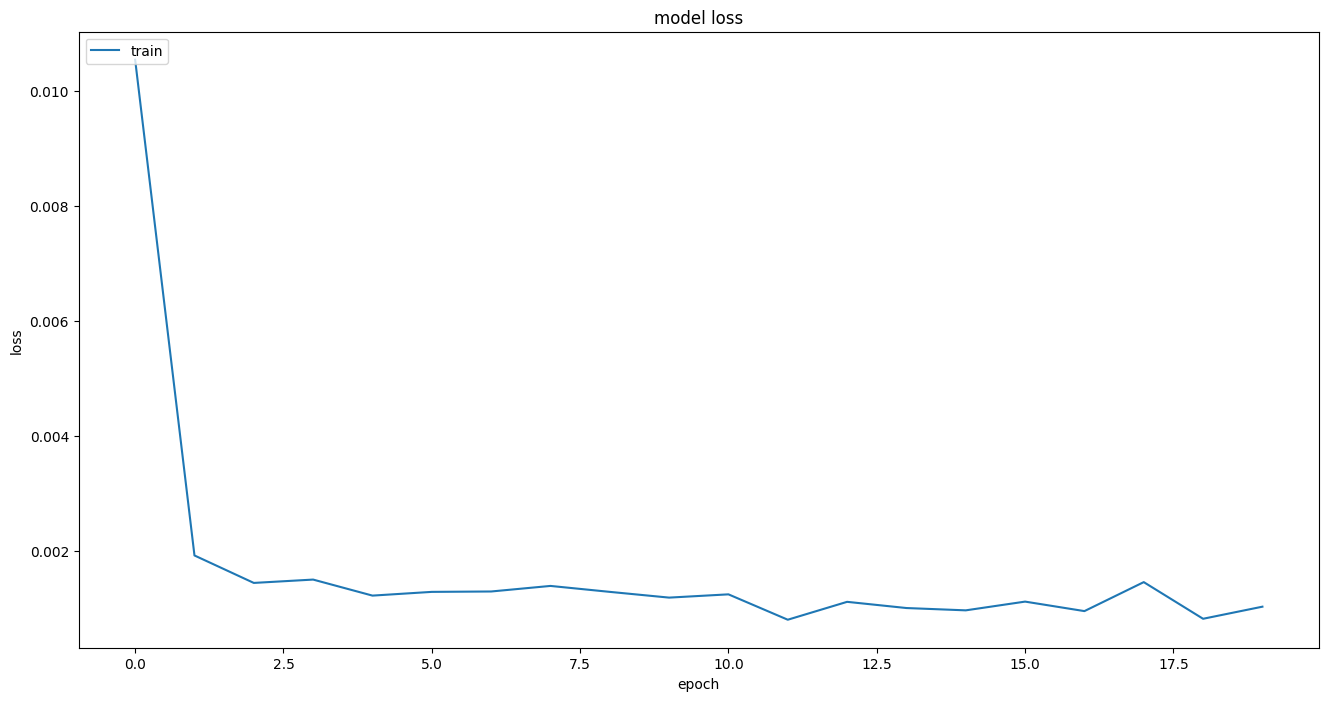

In [ ]:
dec_2020 = '2020-12-31'
mask = (df['Date'] <= dec_2020)
data_20 = df.loc[mask]
mask = (df['Date'] > dec_2020)
data_23 = df.loc[mask]
training_set = data_20.iloc[:,4:5].values
# Scaling the training set using MinMaxScaler (normalize the input to prevent creating a bias)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_training_set = scaler.fit_transform(training_set)

# Creating input sequences and corresponding labels
X_train = []
y_train = []
for i in range(60, 1795):
    X_train.append(scaled_training_set[i-60:i, 0])
    y_train.append(scaled_training_set[i, 0])
# X_train.shape = (1795, 60)
# y_train.shape = (1795,)

# Converting lists to NumPy arrays
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping input data to be 3-dimensional for LSTM input
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Building the LSTM model
model = Sequential()

model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.2))

# Adding a Dense layer for output
model.add(Dense(units=1))

# Compiling the model with Adam optimizer and mean squared error loss
model.compile(optimizer='adam', loss="mean_squared_error")

hist = model.fit(X_train, y_train, epochs = 20, batch_size = 32, verbose=2)
plt.figure(figsize = (16, 8))
plt.plot(hist.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.savefig('stockLoss.svg', format='svg', bbox_inches='tight')
plt.show()

In [ ]:
# Extracting the testing set from data_23
testing_set = data_23.iloc[:, 4:5]

# Extracting labels for testing set
y_test = testing_set.iloc[60:, 0:].values

# Converting testing_set to a NumPy array
testing_set = testing_set.iloc[:, 0:].values

# Scaling the testing set using the previously fitted scaler
scaled_testing_set = scaler.transform(testing_set)
scaled_testing_set.shape

(720, 1)

21/21 [==============================] - 1s 35ms/step


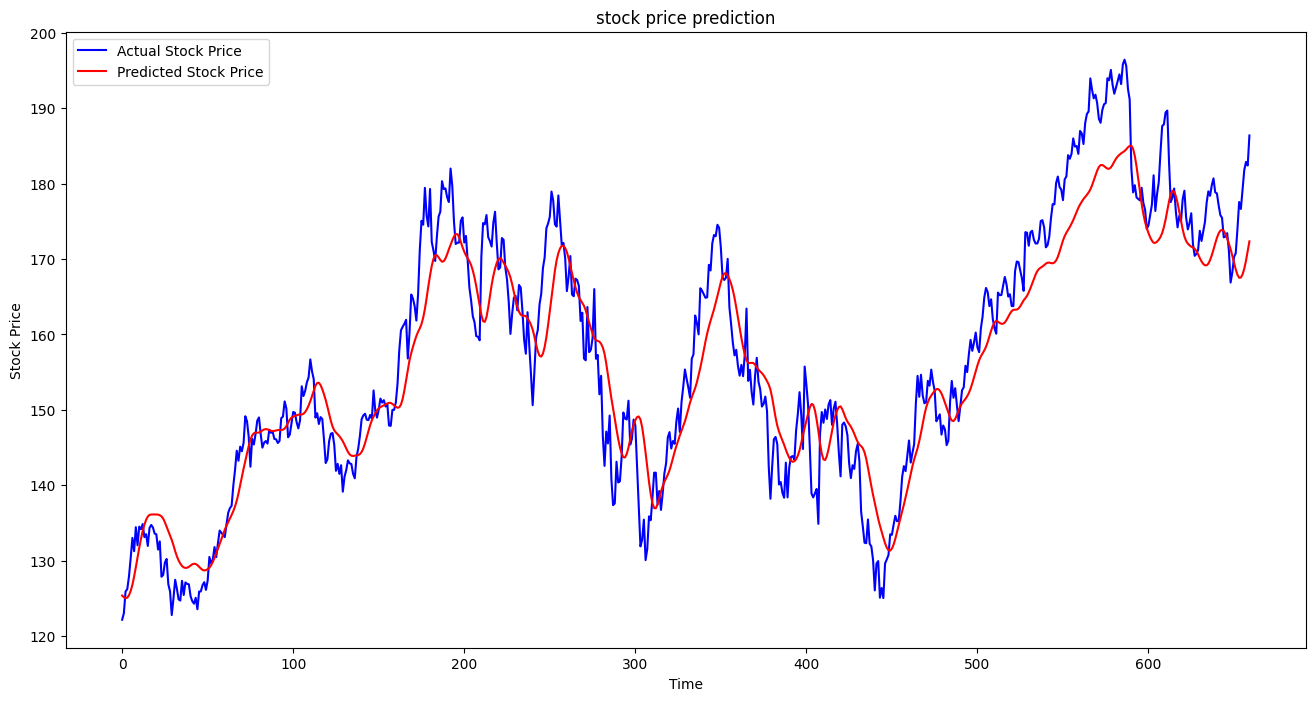

In [ ]:
# list to store input sequences for testing
X_test = []
for i in range(60, 720):
    X_test.append(scaled_testing_set[i-60:i, 0])
X_test = np.array(X_test)

# Reshaping the input data to be 3-dimensional for LSTM input
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Making predictions using the trained model
y_pred = model.predict(X_test)

# Inverse transforming the predicted prices to the original scale
predicted_price = scaler.inverse_transform(y_pred)
plt.figure(figsize = (16, 8))

plt.plot(y_test, color = 'blue', label = 'Actual Stock Price')
plt.plot(predicted_price, color = 'red', label = 'Predicted Stock Price')
plt.title('stock price prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.savefig('stock.svg', format='svg', bbox_inches='tight', dpi = 600)
plt.show()